# Clustering data processing: Ganglion Cells in the Retina
- **Author:** David Felipe
- **Contact:** https://github.com/davidnfu0
- **Last Modification:** January 25, 2024
- **Description:** This notebook is used to process the data from the retina ganglion cells. 
- **Note:** In this document, you can modify the parameters of the PCA to adjust the models to new requirements.

## Introduction

### Importing libraries

In [28]:
import sys
import numpy as np
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

In [29]:
sys.path.append("../../")

In [30]:
from scripts import load_yaml_config, pca_information_loss

### Paths, constants and configuration

In [31]:
plt.style.use("seaborn-v0_8-darkgrid")

In [32]:
configPath = "../../config/"
config = load_yaml_config(configPath + "general_config.yml")

### Loading data

In [33]:
with open("../.." + config["paths"]["data_cache"]["RFS"], "rb") as file:
    RFS = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["T_DATA_STA"], "rb") as file:
    T_DATA_STA = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["TOTAL_SPIKES"], "rb") as file:
    TOTAL_SPIKES = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["BINS_STIM_DICT"], "rb") as file:
    BINS_STIM_DICT = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["FUNC_BANDWIDTH"], "rb") as file:
    FUNC_BANDWIDHT = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["FUNC_HWHH"], "rb") as file:
    FUNC_HWHH = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["FUNC_PEAKS"], "rb") as file:
    FUNC_PEAKS = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["FUNC_ROOTS"], "rb") as file:
    FUNC_ROOTS = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["POLY_BANDWIDTH"], "rb") as file:
    POLY_BANDWIDHT = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["POLY_HWHH"], "rb") as file:
    POLY_HWHH = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["POLY_PEAKS"], "rb") as file:
    POLY_PEAKS = pickle.load(file)
with open("../.." + config["paths"]["data_cache"]["POLY_ROOTS"], "rb") as file:
    POLY_ROOTS = pickle.load(file)
TEMPS_STIM = np.array(list(BINS_STIM_DICT.keys()))
TEMPS_RFS = np.array([temp for temp in RFS.keys() if temp in BINS_STIM_DICT.keys() and temp in TOTAL_SPIKES.keys()])

## Data dict

In [34]:
staDataDict = {}

In [35]:
for temp in TEMPS_RFS:
    staDataDict[temp] = {
        "x": None,
        "y": None,
        "w": None,
        "h": None,
        "a": None,
        "exc": None,
        "area": None,
        "total_spikes": None,
        "peak_poly": None,
        "time_to_peak_poly": None,
        "array_peak_position_poly": None,
        "hwhh_x_poly": None,
        "hwhh_y_poly": None,
        "bandwidth_poly": None,
        "zero_crossing_poly": None,
        "peak_func": None,
        "time_to_peak_func": None,
        "array_peak_position_func": None,
        "hwhh_x_func": None,
        "hwhh_y_func": None,
        "bandwidth_func": None,
        "zero_crossing_func": None,
    }
    tempDict = staDataDict[temp]

    for var in RFS[temp].keys():
        tempDict[var] = RFS[temp][var]

    tempDict["area"] = RFS[temp]["w"] * RFS[temp]["h"]
    tempDict["total_spikes"] = TOTAL_SPIKES[temp]

    if POLY_PEAKS[temp]["max"] is not None:
        tempDict["peak_poly"] = POLY_PEAKS[temp]["max"][1]
        tempDict["time_to_peak_poly"] = POLY_PEAKS[temp]["max"][0]
        tempDict["array_peak_position_poly"] = POLY_PEAKS[temp]["max"][2]
    elif POLY_PEAKS[temp]["min"] is not None:
        tempDict["peak_poly"] = POLY_PEAKS[temp]["min"][1]
        tempDict["time_to_peak_poly"] = POLY_PEAKS[temp]["min"][0]
        tempDict["array_peak_position_poly"] = POLY_PEAKS[temp]["min"][2]
    else:
        print("MISS POLY PEAK:", temp)
    if POLY_HWHH[temp] is not None:
        tempDict["hwhh_x_poly"] = POLY_HWHH[temp][0]
        tempDict["hwhh_y_poly"] = POLY_HWHH[temp][1]
    else:
        print("MISS POLY HWHH:", temp)
    tempDict["bandwidth_poly"] = POLY_BANDWIDHT[temp]
    tempDict["zero_crossing_poly"] = POLY_ROOTS[temp]["ZC"]

    if FUNC_PEAKS[temp]["max"] is not None:
        tempDict["peak_func"] = FUNC_PEAKS[temp]["max"][1]
        tempDict["time_to_peak_func"] = FUNC_PEAKS[temp]["max"][0]
        tempDict["array_peak_position_func"] = FUNC_PEAKS[temp]["max"][2]
    elif FUNC_PEAKS[temp]["min"] is not None:
        tempDict["peak_func"] = FUNC_PEAKS[temp]["min"][1]
        tempDict["time_to_peak_func"] = FUNC_PEAKS[temp]["min"][0]
        tempDict["array_peak_position_func"] = FUNC_PEAKS[temp]["min"][2]
    else:
        print("MISS FUNC PEAK:", temp)
    if FUNC_HWHH[temp] is not None:
        tempDict["hwhh_x_func"] = FUNC_HWHH[temp][0]
        tempDict["hwhh_y_func"] = FUNC_HWHH[temp][1]
    else:
        print("MISS FUNC HWHH:", temp)
    tempDict["bandwidth_func"] = FUNC_BANDWIDHT[temp]
    tempDict["zero_crossing_func"] = FUNC_ROOTS[temp]["ZC"]

MISS POLY HWHH: temp_100
MISS POLY HWHH: temp_102
MISS POLY HWHH: temp_115
MISS POLY HWHH: temp_118
MISS POLY HWHH: temp_131
MISS POLY HWHH: temp_330
MISS FUNC PEAK: temp_347
MISS FUNC HWHH: temp_347
MISS FUNC HWHH: temp_387
MISS POLY HWHH: temp_412
MISS FUNC PEAK: temp_412
MISS FUNC HWHH: temp_412
MISS FUNC HWHH: temp_431
MISS POLY HWHH: temp_434
MISS POLY HWHH: temp_45
MISS POLY HWHH: temp_460
MISS FUNC HWHH: temp_460
MISS POLY HWHH: temp_468
MISS FUNC HWHH: temp_487
MISS POLY HWHH: temp_52
MISS POLY HWHH: temp_521
MISS POLY HWHH: temp_536
MISS FUNC HWHH: temp_536
MISS FUNC HWHH: temp_549
MISS POLY HWHH: temp_553
MISS FUNC PEAK: temp_556
MISS FUNC HWHH: temp_556
MISS POLY HWHH: temp_587
MISS FUNC PEAK: temp_587
MISS FUNC HWHH: temp_587
MISS FUNC PEAK: temp_597
MISS FUNC HWHH: temp_597
MISS POLY HWHH: temp_612
MISS POLY HWHH: temp_621
MISS POLY HWHH: temp_647
MISS POLY HWHH: temp_99


In [36]:
staDf = pd.DataFrame.from_dict(staDataDict, orient="index")
staDf.reset_index(inplace=True)
staDf.rename(columns={"index": "template"}, inplace=True)
staDf.dropna(inplace=True)
scaler = StandardScaler()
staScaler = scaler.fit_transform(staDf.iloc[:, 1:])
staNorm = pd.DataFrame(normalize(staScaler), index=staDf["template"])
staNorm.columns = staDf.columns[1:]
TEMPS_STA = staDf["template"].values

### Stim dict

In [37]:
PROTOCOLS = []
for protocolDescription in list(BINS_STIM_DICT[TEMPS_STIM[0]].keys()):
    protocol = protocolDescription.split(".")[0]
    if protocol not in PROTOCOLS:
        PROTOCOLS.append(protocol)

In [38]:
stimDict = {protocol: {} for protocol in PROTOCOLS}
for protocol, table in stimDict.items():
    for temp in TEMPS_STIM:
        if temp not in table:
            table[temp] = {}
        for protocolDescription, repetitions in BINS_STIM_DICT[temp].items():
            if protocolDescription.split(".")[0] == protocol:
                num_repetition = len(repetitions)
                for repetition, spikes in repetitions.items():
                    for bin, spike in enumerate(spikes):
                        key = f"avg-{protocolDescription}-bin_{bin}"
                        if key not in table[temp]:
                            table[temp][key] = 0
                        table[temp][key] += spike
                for bin in range(len(spikes)):
                    key = f"avg-{protocolDescription}-bin_{bin}"
                    table[temp][key] /= num_repetition

In [39]:
stimDfsDict = {}
for protocol, table in stimDict.items():
    stimDfsDict[protocol] = pd.DataFrame.from_dict(table, orient="index")

In [40]:
for df in stimDfsDict.values():
    df.fillna(0, inplace=True)

In [41]:
if "template" not in list(stimDfsDict[PROTOCOLS[0]].columns):
    for df in stimDfsDict.values():
        df.reset_index(inplace=True)
        df.rename(columns={"index": "template"}, inplace=True)
    print("Added template column")
else:
    print("Already has template column")

Added template column


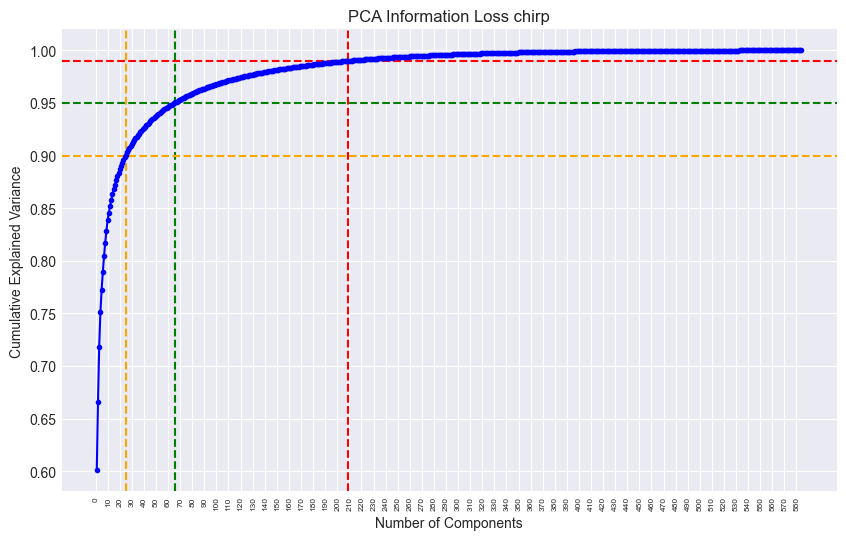

In [42]:
for df_name, df in stimDfsDict.items():
    if df_name == "chirp":
        if len(df.columns) > 3:
            pca_information_loss(
                df_name,
                df.drop((["template"]), axis=1).dropna(),
                max_components=min(len(df.dropna()) - 1, len(df.columns) - 1),
            )

In [43]:
scaler = StandardScaler()
stimNormDict = {}

for df_name, df in stimDfsDict.items():
    if df_name == "chirp":
        scaled_df = scaler.fit_transform(df.iloc[:, 1:])
        df_norm = normalize(scaled_df)
        stimNormDict[df_name] = pd.DataFrame(df_norm, index=df["template"])

In [44]:
stimDimensionDict = {
    "chirp": 70,
}
print("Stimulus dimensionality:", sum(stimDimensionDict.values()))

Stimulus dimensionality: 70


In [45]:
stimPCADict = {}
for df_name, df in stimNormDict.items():
    if df_name in stimDimensionDict.keys():
        pca = PCA(n_components=stimDimensionDict[df_name])
        pca.fit(df)
        stimPCADict[df_name] = pd.DataFrame(pca.transform(df), index=df.index)
    else:
        print(f"Missing dimension for {df_name}")

In [46]:
for df_name, df in stimPCADict.items():
    df_columns = []
    for i in range(df.shape[1]):
        df_columns.append(f"{df_name}-comp_{i+1}")
    df.columns = df_columns

In [47]:
stimDf = pd.concat(stimPCADict.values(), axis=1)

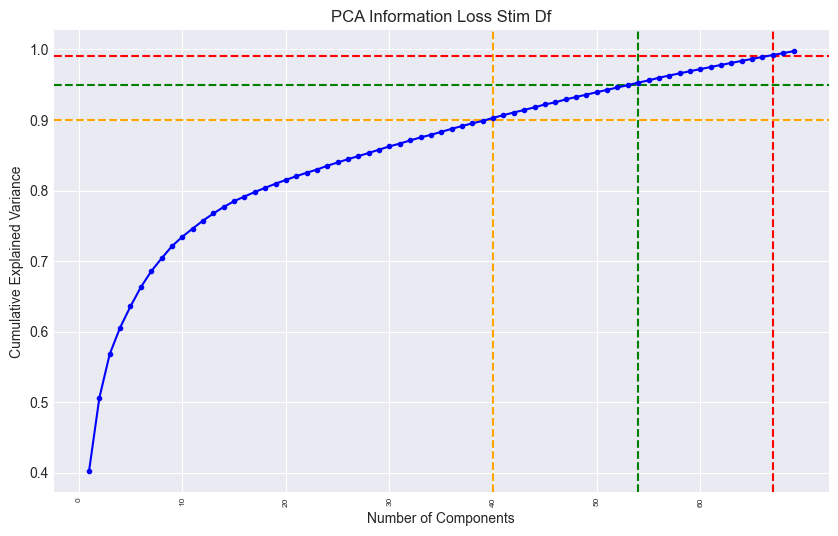

In [48]:
pca_information_loss(
    "Stim Df", stimDf, max_components=min(stimDf.shape[0] - 1, stimDf.shape[1] - 1)
)

In [49]:
if len(stimDimensionDict.keys()) > 1:
    pca = PCA(n_components=60)
    pca.fit(stimDf)
    stimPca = pd.DataFrame(pca.transform(stimDf), index=stimDf.index)
    stimPcaColumns = stimPca.columns
    newStimPcaColumns = []
    for col in stimPcaColumns:
        newStimPcaColumns.append("stim_pca_comp_" + str(col))
    stimPca.columns = newStimPcaColumns
else:
    stimPca = stimDf

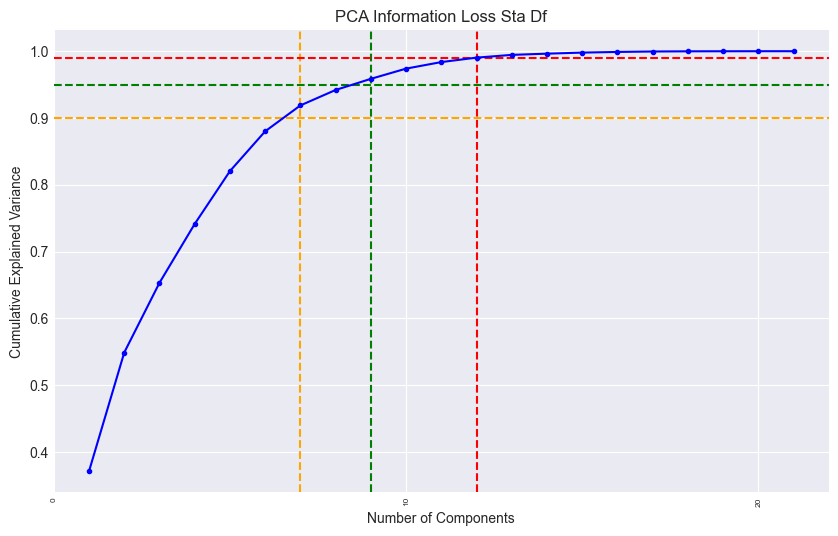

In [50]:
pca_information_loss(
    "Sta Df", staNorm, max_components=min(staNorm.shape[0] - 1, staNorm.shape[1] - 1)
)

In [51]:
pca = PCA(n_components=15)
pca.fit(staNorm)
staPca = pd.DataFrame(pca.transform(staNorm), index=staNorm.index)
staPcaColumns = staPca.columns
newStaPcaColumns = []
for col in staPcaColumns:
    newStaPcaColumns.append("sta_pca_comp_" + str(col))
staPca.columns = newStaPcaColumns

## Export the data

In [52]:
stimPaths = ["chirp_df", "checkerboard_df", "natural_images_df", "ensembles_df"]
for stimPath in stimPaths:
    stimDfsDict[stimPath.replace("_df", "")].to_csv(
        "../.." + config["paths"]["data"][stimPath], index=True
    )
stimDf.to_csv("../.." + config["paths"]["data"]["stim_df"], index=True)
stimPca.to_csv("../.." + config["paths"]["data"]["stim_pca_df"], index=True)
staDf.to_csv("../.." + config["paths"]["data"]["sta_og_df"], index=True)
staNorm.to_csv("../.." + config["paths"]["data"]["sta_df"], index=True)
staPca.to_csv("../.." + config["paths"]["data"]["sta_pca_df"], index=True)

___